In [1]:



import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np


def create_stretched_colormap(cmap, levels):
    """
    Create a stretched colormap.

    cmap: Original colormap instance
    levels: List or array of levels where the colormap should be stretched
    """
    # Normalize the levels to the range [0, 1]
    levels = np.array(levels)
    norm_levels = (levels - levels.min()) / (levels.max() - levels.min())

    # Create a new colormap using LinearSegmentedColormap
    cdict = {'red': [], 'green': [], 'blue': []}

    for i, level in enumerate(norm_levels):
        r, g, b, _ = cmap(level)
        cdict['red'].append((level, r, r))
        cdict['green'].append((level, g, g))
        cdict['blue'].append((level, b, b))

    return mcolors.LinearSegmentedColormap('StretchedCMap', cdict)


def color(c, unique_c):
    cm = plt.cm.get_cmap('PuOr')
    return cm(plt.Normalize(np.min(unique_c), np.max(unique_c))(c))


In [2]:
# Load results into arrays of same names
ndims = 8
save_file = f"experiment_results_{ndims}D.npz"

npzfile = np.load(save_file)
log_Z_mean_array = npzfile['log_Z_mean_array'].mean(-1)  # (num_s, num_k, num_c)
log_Z_uncert_array = npzfile['log_Z_uncert_array'].mean(-1)  # (num_s, num_k, num_c)
num_likelihood_evals_array = npzfile['num_likelihood_evals_array'].mean(-1)  # (num_s, num_k, num_c)
total_num_samples_array = npzfile['total_num_samples_array'].mean(-1)  # (num_s, num_k, num_c)
total_num_phantom_samples_array = npzfile['total_num_phantom_samples_array'].mean(-1)  # (num_s, num_k, num_c)
s_array = npzfile['s_array']
k_array = npzfile['k_array']
c_array = npzfile['c_array']

num_s, num_k, num_c, ensemble_size = npzfile['log_Z_mean_array'].shape

# Sample log_Z to propagate uncertainty into ensemble averages
num_samples = 1000
log_Z_samples = npzfile['log_Z_mean_array'][..., None] + npzfile['log_Z_uncert_array'][..., None] * np.random.normal(
    size=(num_samples,))  # (num_s, num_k, num_c, ensemble_size, num_samples)
log_Z_samples = np.reshape(log_Z_samples, (
num_s, num_k, num_c, ensemble_size * num_samples))  # (num_s, num_k, num_c, ensemble_size * num_samples)

# Determine bias relative to asymptote at s=s_max, c=c_max, and k=0 (standard nested sampling)
log_Z_asymptote = np.mean(log_Z_samples[-1, 0, -1, :])  # (ensemble_size*num_samples)
bias_samples = log_Z_samples - log_Z_asymptote  # (num_s, num_k, num_c, ensemble_size*num_samples)
bias = np.mean(bias_samples, axis=-1)  # (num_s, num_k, num_c)
bias_uncert = np.std(bias_samples, axis=-1)  # (num_s, num_k, num_c)

# Determine efficiency improvement relative to standard nested sampling (k=0)
sample_efficiency_array = (npzfile['total_num_samples_array'] / npzfile['num_likelihood_evals_array']).mean(
    -1)  # (num_s, num_k, num_c)
efficiency_improvement_array = sample_efficiency_array / sample_efficiency_array[:, 0:1, :]  # (num_s, num_k, num_c)


# After a threshold number of slices, the bias is independent of the number of phantom samples
A crucial component of nested sampling is generating i.i.d. uniform samples from the likelihood constrained prior distribution. When using Markov chain likelihood samplers, such as slice sampling, this is accomplished by sequentially drawing samples from an ergodic Markov chain. A well known problem is that if the number of proposals between acceptance is too low the samples with exhibit auto-correlation.

We directly observed this below by looking at bias in the resulting uncertainty estimate as a function of the number of proposal steps between acceptance. Crucially this property is independent of the number of phantom samples, which forms the crux of our discovery. Each point below corresponds to a particular fraction of phantom samples, and number of slices. In general, the bias decreases with increasing number of slices, and increasing phantom fraction. However, after a threshold number of slices, the bias is independent of the  phantom fraction. This is a crucial result, as it means that we can use a smaller number of likelihood evaluations to generate a larger number of i.i.d. samples from the likelihood constrained prior distribution, and thus achieve a high sample efficiency.

/tmp/ipykernel_104572/1306734269.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('PuOr')


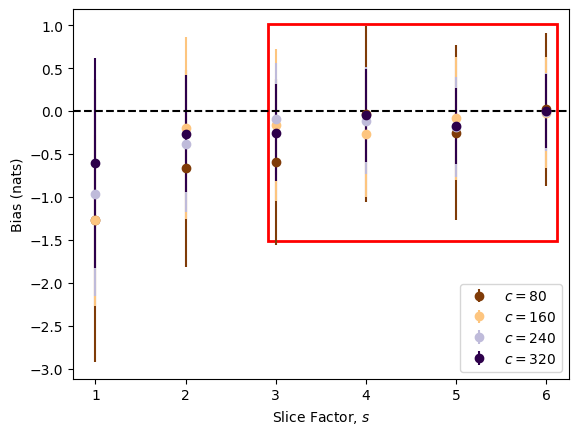

In [3]:
# Plot bias (with error bars) vs s, color coded by c, for k=0

plt.figure()
unique_c = np.unique(c_array)
for i, c in enumerate(c_array):
    plt.errorbar(s_array, bias[:, 0, i], yerr=bias_uncert[:, 0, i], fmt='o', c=color(c, unique_c),
                 label=rf"$c={c}$")
plt.xlabel(r"Slice Factor, $s$")
plt.ylabel("Bias (nats)")
plt.gca().axhline(0, color='k', linestyle='--')
plt.legend(loc='lower right')

# Put a red box around s>=3

x = s_array[s_array >= 3]
y = bias[s_array >= 3, 0, :]
y_uncert = bias_uncert[s_array >= 3, 0, :]
x_range = (x.min() * 0.97, x.max() * 1.02)
y_range = ((y - y_uncert).min() * 0.97, (y + y_uncert).max() * 1.02)

plt.gca().add_patch(plt.Rectangle((x_range[0], y_range[0]), x_range[1] - x_range[0], y_range[1] - y_range[0],
                                  fill=False, edgecolor='r', lw=2, zorder=0))
plt.show()


/tmp/ipykernel_104572/1306734269.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('PuOr')


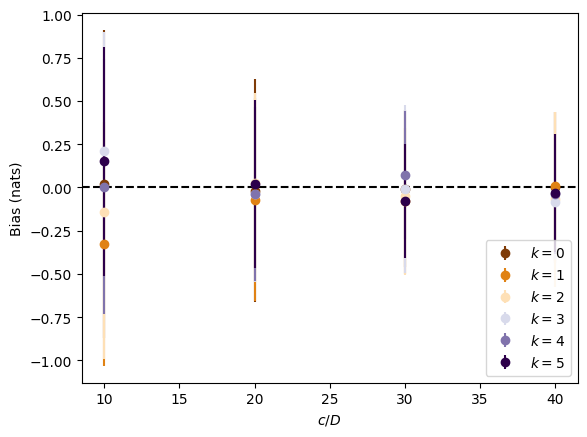

In [4]:
# Plot bias (with error bars) vs c, color coded by k, for s=s_max

plt.figure()
unique_k = np.unique(k_array)
for i, k in enumerate(k_array):
    plt.errorbar(c_array / ndims, bias[-1, i, :], yerr=bias_uncert[-1, i, :], fmt='o', c=color(k, unique_k),
                 label=fr"$k={k}$")

plt.xlabel(f"$c/D$")
plt.ylabel("Bias (nats)")
plt.gca().axhline(0, color='k', linestyle='--')
plt.legend(loc='lower right')
plt.show()


/tmp/ipykernel_104572/1306734269.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('PuOr')


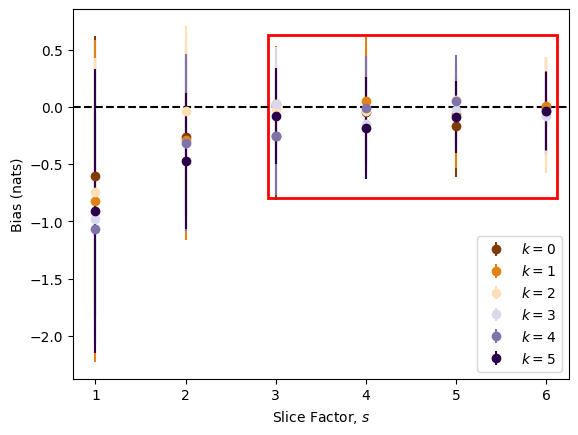

In [5]:
# Plot bias (with error bars) vs s, color coded by k, for c=c_max

plt.figure()
unique_k = np.unique(k_array)
for i, k in enumerate(k_array):
    plt.errorbar(s_array, bias[:, i, -1], yerr=bias_uncert[:, i, -1], fmt='o', c=color(k, unique_k),
                 label=fr"$k={k}$")
plt.xlabel(r"Slice Factor, $s$")
plt.ylabel("Bias (nats)")
plt.gca().axhline(0, color='k', linestyle='--')
plt.legend(loc='lower right')

# Put a red box around s>=3

x = s_array[s_array >= 3]
y = bias[s_array >= 3, :, -1]
y_uncert = bias_uncert[s_array >= 3, :, -1]
x_range = (x.min() * 0.97, x.max() * 1.02)
y_range = ((y - y_uncert).min() * 0.97, (y + y_uncert).max() * 1.02)

plt.gca().add_patch(plt.Rectangle((x_range[0], y_range[0]), x_range[1] - x_range[0], y_range[1] - y_range[0],
                                  fill=False, edgecolor='r', lw=2, zorder=0))

plt.savefig("bias_vs_s.pdf", bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()


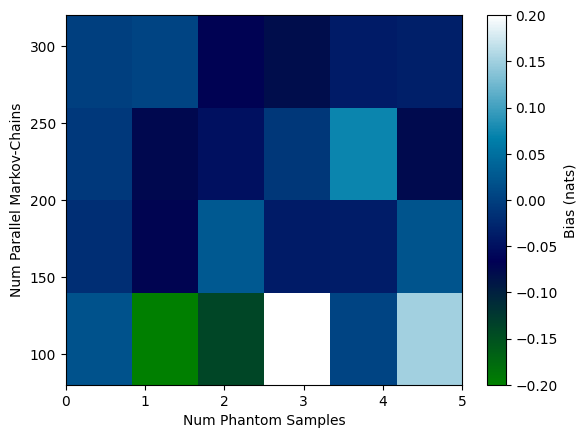

In [6]:
# Plot image of bias vs k and c for s=s_max

plt.figure()
plt.imshow(bias[-1, :, :].T, origin='lower',
           extent=[np.min(k_array), np.max(k_array), np.min(c_array), np.max(c_array)],
           aspect='auto', cmap='ocean', vmin=-0.2, vmax=0.2)
plt.xlabel("Num Phantom Samples")
plt.ylabel("Num Parallel Markov-Chains")
plt.colorbar(label="Bias (nats)")
plt.show()

/tmp/ipykernel_104572/1306734269.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('PuOr')


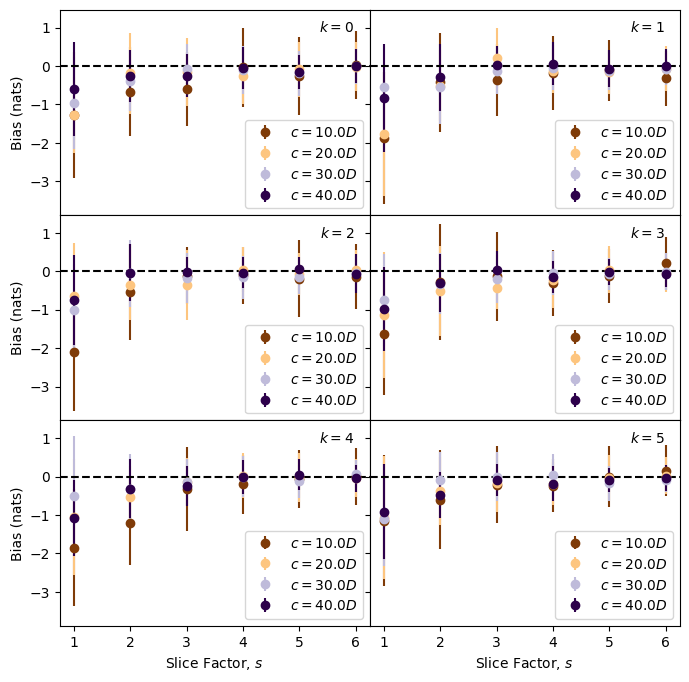

In [7]:
# Plot a grid of panels (3 rows, 2 columns) of the bias vs s, color coded by c, where panels in col 1 are  k=0,1,2 and col 2 are k=3,4,5

# Make axes share x, y
fig, axes = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(8, 8))
unique_c = np.unique(c_array)
for j, k in enumerate(k_array):
    row = j // 2
    col = j % 2
    ax = axes[row, col]
    for i, c in enumerate(c_array):
        ax.errorbar(s_array, bias[:, k, i], yerr=bias_uncert[:, k, i], fmt='o', c=color(c, unique_c),
                    label=rf"$c={c / ndims}D$")
    ax.legend(loc='lower right')
    ax.axhline(0, color='k', linestyle='--')
    # Put label in top right corner for k-value of panel
    ax.text(0.95, 0.95, fr"$k={k}$", transform=ax.transAxes, ha='right', va='top')

# Make space between axes disappear
plt.subplots_adjust(wspace=0, hspace=0)

# Put x-labels on bottom row, and y-labels on left column
for col in range(2):
    for row in range(3):
        ax = axes[row, col]
        if row == 2:
            ax.set_xlabel(r"Slice Factor, $s$")
        if col == 0:
            ax.set_ylabel("Bias (nats)")
        # if col == 1:
        #     ax.set_yticklabels([])
        # if row != 2:
        #     ax.set_xticklabels([])

plt.show()




/tmp/ipykernel_104572/1306734269.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('PuOr')


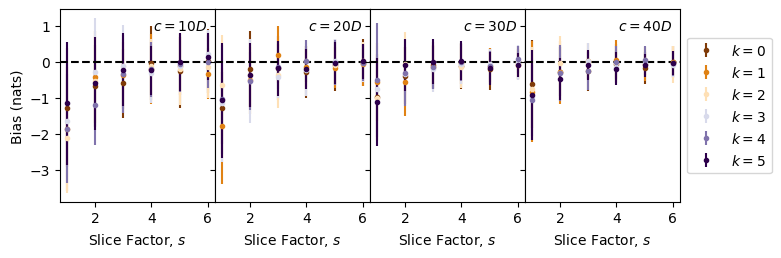

In [8]:
# Plot a grid of panels (1 rows, 4 columns) of the bias vs s, color coded by k, where panels in col 1 are  c=0,  col 2 are c=1, col 3 are c=2, and col 4 are c=3

# Make axes share x, y
fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(8, 2.5))
unique_k = np.unique(k_array)

for j, c in enumerate(c_array):
    ax = axes[j]
    for i, k in enumerate(k_array):
        # smaller point size
        ax.errorbar(s_array, bias[:, k, j], yerr=bias_uncert[:, k, j], fmt='.', c=color(k, unique_k), label=rf"$k={k}$")
    ax.axhline(0, color='k', linestyle='--')
    # Put label in top right corner for k-value of panel
    ax.text(0.95, 0.95, fr"$c={c // ndims:d}D$", transform=ax.transAxes, ha='right', va='top')

# Put a single legend to the right of the right-most column
axes[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Make space between axes disappear
plt.subplots_adjust(wspace=0, hspace=0)

# Put x-labels on bottom row, and y-labels on left column
for col in range(4):
    ax = axes[col]
    ax.set_xlabel(r"Slice Factor, $s$")
    if col == 0:
        ax.set_ylabel("Bias (nats)")

plt.savefig(f"bias_vs_s_grid_per_c_{ndims}D.pdf", bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()


/tmp/ipykernel_104572/1306734269.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('PuOr')


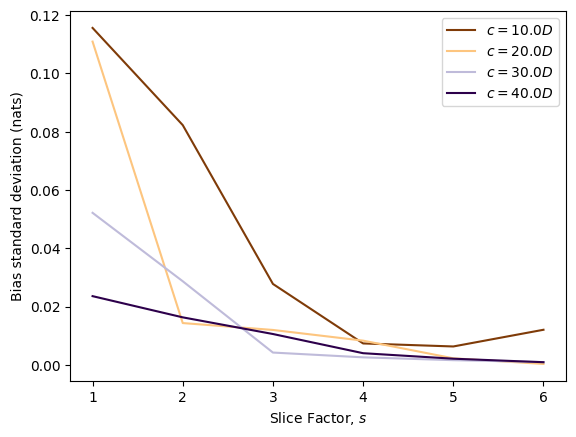

In [9]:
# Define consistency h=std(abs(bias)) over k dimension
# Plot h vs s, color coded by c

h = np.var(np.abs(bias), axis=1)

plt.figure()
unique_c = np.unique(c_array)
for i, c in enumerate(c_array):
    plt.plot(s_array, h[:, i], ls='-', c=color(c, unique_c), label=rf"$c={c / ndims}D$")
plt.xlabel(r"Slice Factor, $s$")
plt.ylabel(r"Bias standard deviation (nats)")
plt.legend(loc='upper right')
plt.savefig("consistency_vs_s.pdf", bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

# Using phantom samples to improve sample efficiency
Using the above result, the sample efficiency can be significantly boosted by using a large enough number of slices, and larger phantom fraction. We can easily see this looking at bias vs run time speed up. The run time speed is defined as the ratio of the run time with no phantom samples to the run time with phantom samples. We see a speed up of almost 4x with a phantom fraction of 0.8, and slice factor >= 3. This is a significant improvement in sample efficiency, and is the key to achieving high sample efficiency with nested sampling in high dimensions.

/tmp/ipykernel_104572/1306734269.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('PuOr')


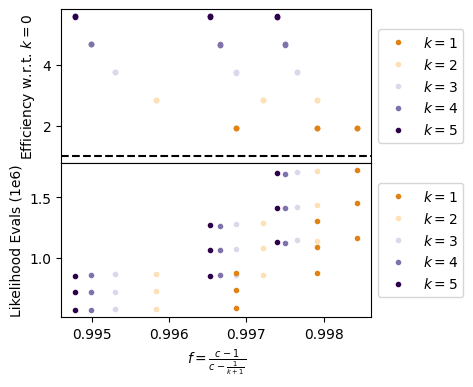

In [10]:
# Plot two panels on top of each other which share x axis. The x-axis is f, for k>0. The top panels is sampling efficiency improvement (for s=s_max) colored by k, and the bottom panel is number of likelihood evaluations for only s=s_max colored by k.

# Make axes share x
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(4, 4))
unique_s = np.unique(s_array)
for i, s in enumerate(s_array):
    for j, k in enumerate(k_array):
        if k == 0:
            continue
        for l, c in enumerate(c_array):
            if s < 4:
                continue
            if c < 20 * ndims:
                continue
            f = (c - 1) / (c - 1 / (k + 1))
            axes[0].plot(f, efficiency_improvement_array[i, j, l], '.', c=color(k, unique_k))
            axes[1].plot(f, num_likelihood_evals_array[i, j, l] * 1e-6, '.', c=color(k, unique_k))
axes[0].set_ylabel(r"Efficiency w.r.t. $k=0$")
axes[1].set_ylabel("Likelihood Evals (1e6)")
axes[1].set_xlabel(r"$f = \frac{c - 1}{c - \frac{1}{k+1}}$")
axes[0].axhline(1, color='k', linestyle='--')
# Remove space between axes
plt.subplots_adjust(wspace=0, hspace=0)
# K legend
for k in unique_k:
    if k == 0:
        continue
    axes[0].plot([], [], '.', c=color(k, unique_k), label=fr"$k={k}$")
    axes[1].plot([], [], '.', c=color(k, unique_k), label=fr"$k={k}$")

# Put a single legend to the right of the right-most column
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# # Put each s label in once
# for s in unique_s:
#     if s < 3:
#         continue
#     axes[1].plot([], [], 'o', c=color(s, unique_s), label=fr"$s={s}$")
plt.savefig(f"speedup_and_likelihood_vs_f_per_k_{ndims}D.pdf", bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

# Ablation study, large values of phantom fraction should introduce autocorrelation

We explore the impact of large values of phantom fraction on the resulting bias. We see that for large values of phantom fraction, the bias increases significantly. This is due to the fact that the phantom samples are no longer i.i.d. and thus the resulting log-evidence estimate is biased.

We restrict ourselves to `slice_factor=6` as this is the largest value of slice factor we consider, and thus the bias is independent of the number of slices. We explore `num_phantom` from `{s, 2*s, ..., s * (D-1) - 1, s * D - 1}`.


In [11]:
# Load results into arrays of same names
ndims = 8
save_file = f"ablation_results_{ndims}D.npz"

npzfile = np.load(save_file)
log_Z_mean_array = npzfile['log_Z_mean_array'].mean(-1)  # (num_s, num_k, num_c)
log_Z_uncert_array = npzfile['log_Z_uncert_array'].mean(-1)  # (num_s, num_k, num_c)
num_likelihood_evals_array = npzfile['num_likelihood_evals_array'].mean(-1)  # (num_s, num_k, num_c)
total_num_samples_array = npzfile['total_num_samples_array'].mean(-1)  # (num_s, num_k, num_c)
total_num_phantom_samples_array = npzfile['total_num_phantom_samples_array'].mean(-1)  # (num_s, num_k, num_c)
s_array = npzfile['s_array']
k_array = npzfile['k_array']
c_array = npzfile['c_array']

num_s, num_k, num_c, ensemble_size = npzfile['log_Z_mean_array'].shape

# Sample log_Z to propagate uncertainty into ensemble averages
num_samples = 1000
log_Z_samples = npzfile['log_Z_mean_array'][..., None] + npzfile['log_Z_uncert_array'][..., None] * np.random.normal(
    size=(num_samples,))  # (num_s, num_k, num_c, ensemble_size, num_samples)
log_Z_samples = np.reshape(log_Z_samples, (
num_s, num_k, num_c, ensemble_size * num_samples))  # (num_s, num_k, num_c, ensemble_size * num_samples)

bias_samples = log_Z_samples - log_Z_asymptote  # (num_s, num_k, num_c, ensemble_size*num_samples)
bias = np.mean(bias_samples, axis=-1)  # (num_s, num_k, num_c)
bias_uncert = np.std(bias_samples, axis=-1)  # (num_s, num_k, num_c)



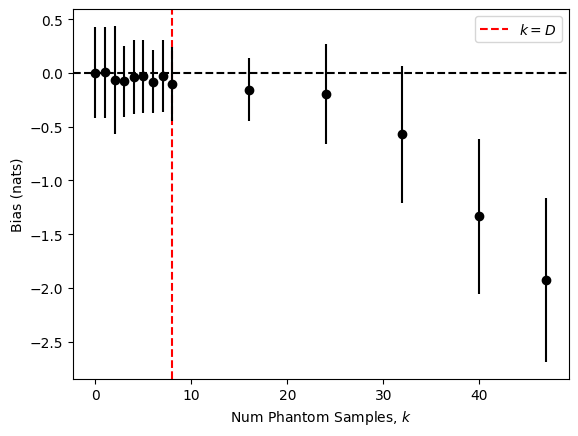

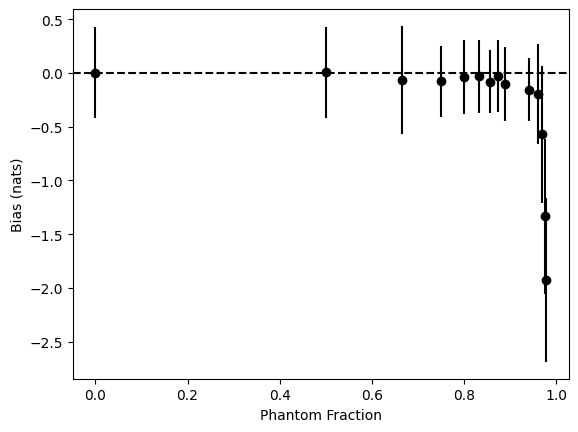

In [12]:
# Plot bias with rms y error bars vs k, with vertical red dashed line a k=2*D

plt.figure()
plt.errorbar(k_array, bias[0, :, 0], yerr=bias_uncert[0, :, 0], fmt='o', c='k')
plt.xlabel(r"Num Phantom Samples, $k$")
plt.ylabel("Bias (nats)")
plt.gca().axhline(0, color='k', linestyle='--')
plt.gca().axvline(ndims, color='r', linestyle='--', zorder=0, label=r"$k=D$")
plt.legend(loc='upper right')
plt.savefig(f"ablation_bias_vs_k_{ndims}D.pdf", bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

# Plot bias with rms y error bars vs phantom fraction

plt.figure()
phantom_fraction = k_array / (k_array + 1)
plt.errorbar(phantom_fraction, bias[0, :, 0], yerr=bias_uncert[0, :, 0], fmt='o', c='k')
plt.xlabel("Phantom Fraction")
plt.ylabel("Bias (nats)")
plt.gca().axhline(0, color='k', linestyle='--')
plt.show()

